In [ ]:
import json
import os
import requests

def download_audio_data(json_data, config):
    download_path = os.path.join(config['base_dir'], config['download_path'])
    if not os.path.exists(download_path):
        os.makedirs(download_path)
    json_rows = json_data['rows']
    for i, row in enumerate(json_rows):
        if i > config['max_num_samples']:
            break
        audio_url = row['row']['audio'][0]['src']
        audio_id = row['row_idx']
        audio_path = os.path.join(download_path, f'{audio_id}.wav')
        if os.path.exists(audio_path):
            print(f'{audio_path} already exists. Skipping...')
            continue
        print(f'Downloading {audio_url} to {audio_path}')
        response = requests.get(audio_url)
        with open(audio_path, 'wb') as f:
            f.write(response.content)
    print(f'Downloaded {i} samples')

if __name__ == '__main__':

    config = {
        'base_dir': '/ssd_scratch/cvit/kolubex/.cache/gsoc',
        'download_path': 'peoples_speech_samples',
        'json_path' : 'peoples_speech.json',
        'max_num_samples': 100
    }
    with open(os.path.join(config['base_dir'], config['json_path']), 'r') as f:
        json_data = json.load(f)
    download_audio_data(json_data, config)

In [1]:
import subprocess
import os
import pandas as pd

def download_clip(ytid, start_seconds, end_seconds, output_path):
    # Convert start and end times to HH:MM:SS format
    start_time = f"{int(start_seconds // 3600):02d}:{int((start_seconds % 3600) // 60):02d}:{int(start_seconds % 60):02d}"
    duration = end_seconds - start_seconds

    command = ["yt-dlp", "--youtube-skip-dash-manifest", "-g", f"https://youtu.be/{ytid}"]
    # print command that is being executed
    print(" ".join(command))
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()

    if error:
        print(f"Error fetching URLs for {ytid}: {error}")


    urls = output.decode("utf-8").strip().split("\n")
    if len(urls) != 2:
        print(f"Error fetching URLs for {ytid}: Expected 2 URLs, got {len(urls)}")
        return
    # Download clip using ffmpeg
    ytid_strip = ytid.strip('-')
    ffmpeg_command = [
        "ffmpeg",
        "-ss", start_time,
        "-i", urls[0],  # Video URL
        "-ss", start_time,
        "-i", urls[1],  # Audio URL
        "-ss", "5",
        "-r","5",
        "-ac","1",
        "-map", "0:v", "-map", "1:a",
        "-c:v", "libx264", "-c:a", "aac",
        "-t", str(duration),
        f"{output_path}/{ytid_strip}.mp4"
    ]
    print(" ".join(ffmpeg_command))
    subprocess.run(ffmpeg_command)

def custom_csv_reader_weak(csv_path):
    data = []
    with open(csv_path, 'r') as file:
        for line in file:
            # Skip comments
            if line.startswith('#'):
                continue
            parts = line.strip().split(',', 3)  # Split by the first three commas only
            if len(parts) == 4:  # Ensure the line is correctly formatted
                data.append(parts)
    df = pd.DataFrame(data, columns=["YTID", "start_seconds", "end_seconds", "positive_labels"])
    df = df[150:]
    df["start_seconds"] = df["start_seconds"].astype(float)
    df["end_seconds"] = df["end_seconds"].astype(float)
    return df

def custom_tsv_reader_strong(tsv_path):
    df = pd.read_csv(tsv_path, sep='\t')
    df['YTID'] = df['segment_id'].apply(lambda x: '_'.join(x.split('_')[:-1]))
    df['start_seconds'] = df['segment_id'].apply(lambda x: int(x.split('_')[-1])/1000)
    df['end_seconds'] = df['start_seconds'] + 10
    # group by YTID and take the first row
    df = df.groupby('YTID').first().reset_index()
    df = df[:200]
    return df

def download_clips_from_csv(config):
    # Read CSV, ignoring comments
    # df = custom_csv_reader_weak(csv_path)
    df = custom_tsv_reader_strong(os.path.join(config['base_dir'], config['tsv_path']))
    count = 0
    for _, row in df.iterrows():
        download_clip(row['YTID'], row['start_seconds'], row['end_seconds'], os.path.join(config['base_dir'], config['output_path_tsv'] if config['strong'] else config['output_path_csv']))
        count += 1
        if count > 100:
            break

config = {
    'base_dir': '/ssd_scratch/cvit/kolubex/.cache/gsoc',
    'csv_path': '/workspace/Fast-Audioset-Download/csvs/test_download.csv',
    'tsv_path': 'audioset_train_strong.tsv',
    'output_path_tsv': 'audioset_samples_segments',
    'output_path_csv': 'audioset_samples',
    'strong': True
}
download_clips_from_csv(config)

FileNotFoundError: [Errno 2] No such file or directory: '/ssd_scratch/cvit/kolubex/.cache/gsoc/audioset_train_strong.tsv'

In [1]:
import subprocess
import os
import pandas as pd


def download_clip(ytid, start_seconds, end_seconds, output_path, video_frame_rate=5, audio_sample_rate=16000):
    """
    Downloads a clip from a YouTube video within a specified time range.

    Parameters:
    ytid (str): YouTube video ID.
    start_seconds (float): Start time of the clip in seconds.
    end_seconds (float): End time of the clip in seconds.
    output_path (str): Directory where the output video will be saved.
    video_frame_rate (int): Frame rate of the output video in frames per second.
    audio_sample_rate (int): Sample rate of the output audio in Hz.

    Returns:
    None
    """
    
    # Convert start and end times to HH:MM:SS format
    start_time = f"{int(start_seconds // 3600):02d}:{int((start_seconds % 3600) // 60):02d}:{int(start_seconds % 60):02d}"
    duration = end_seconds - start_seconds

    # Construct the yt-dlp command to get the video and audio URLs
    command = ["yt-dlp", "--youtube-skip-dash-manifest", "-g", f"https://youtu.be/{ytid}"]
    print(" ".join(command))
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()

    if error:
        print(f"Error fetching URLs for {ytid}: {error.decode()}")
        return

    # Decode the output and split by newlines to get separate URLs
    urls = output.decode("utf-8").strip().split("\n")
    if len(urls) != 2:
        print(f"Error fetching URLs for {ytid}: Expected 2 URLs, got {len(urls)}")
        return
    
    # Sanitize the YouTube ID to remove any unsafe characters for filenames
    ytid_strip = ''.join(e for e in ytid if e.isalnum())
    
    # Construct the ffmpeg command to download the clip
    ffmpeg_command = [
        "ffmpeg",
        "-ss", start_time,
        "-i", urls[0],  # Video URL
        "-ss", start_time,
        "-i", urls[1],  # Audio URL
        "-r", str(video_frame_rate),  # Set video frame rate
        "-ar", str(audio_sample_rate),  # Set audio sample rate
        "-ac", "1",  # Set audio channels to mono
        "-map", "0:v", "-map", "1:a",
        "-c:v", "libx264", "-c:a", "aac",
        "-t", str(duration),
        f"{output_path}/{ytid_strip}.mp4"
    ]

    print(" ".join(ffmpeg_command))
    process = subprocess.run(ffmpeg_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    if process.returncode != 0:
        print(f"Error processing video {ytid}: {process.stderr.decode()}")

def read_csv(csv_path):
    df = pd.read_csv(csv_path)
    return df

def download_clips(df, output_path, error_path):
    try:
        for i, row in df.iterrows():
            download_clip(row['YTID'], row['start_seconds'], row['end_seconds'], output_path)
    except Exception as e:
        with open(error_path, 'a' ) as f:
            f.write(f"Error with id {row['YTID']}: {e}\n")
        print(f"Error with id {row['YTID']}: {e}")
        

In [ ]:
def main():
    csv_path = "/tmp/bld56_dataset_v1/audioset/annotations/test_download.csv"
    output_path = "/tmp/bld56_dataset_v1/audioset/videos"
    error_path = "/tmp/bld56_dataset_v1/audioset/download_logs/error.log"
    df = read_csv(csv_path)
    download_clips(df, output_path, error_path)

if __name__ == '__main__':
    main()

In [2]:
download_clip('--dr8rXrv8k',0,40,'temps')

yt-dlp --youtube-skip-dash-manifest -g https://youtu.be/--dr8rXrv8k


ffmpeg -ss 00:00:00 -i https://rr4---sn-p5qddn7r.googlevideo.com/videoplayback?expire=1715911888&ei=cGhGZtyuHZWMkucPmOiMkAM&ip=169.59.188.204&id=o-AOT9yaZMeTMnFEBfBfCj3INzPX92GyJiD5qVEF_fN8f0&itag=244&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&mh=wy&mm=31%2C26&mn=sn-p5qddn7r%2Csn-q4flrnee&ms=au%2Conr&mv=m&mvi=4&pl=18&initcwndbps=1635000&vprv=1&svpuc=1&mime=video%2Fwebm&rqh=1&gir=yes&clen=1484260&dur=32.800&lmt=1700527901682551&mt=1715889889&fvip=1&keepalive=yes&c=IOS&txp=1437434&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cxpc%2Cvprv%2Csvpuc%2Cmime%2Crqh%2Cgir%2Cclen%2Cdur%2Clmt&sig=AJfQdSswRgIhAORRu6CpJj87BrIkn-jr6Rd9SuqPBPDR6BavL1UWxFpQAiEA0HNz481yiFP_g66iozT_fDIMgSTdXsyk8ATVO4KHeW0%3D&lsparams=mh%2Cmm%2Cmn%2Cms%2Cmv%2Cmvi%2Cpl%2Cinitcwndbps&lsig=AHWaYeowRgIhAKqegrNAvYQopTAM8paKcIExOs9Cz8amaCfAR5HTwXojAiEAuwd_UhZR7qzZInXV7wFb3bRMUJ1poPWzeZVK4tkspKg%3D -ss 00:00:00 -i https://rr4---sn-p5qddn7r.googlevideo.com/videoplayback?expire=1715911887&ei=b2hGZoidOKCBy_sPr

In [1]:
import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt

def custom_tsv_reader_strong(tsv_path):
    df = pd.read_csv(tsv_path, sep='\t')
    df['YTID'] = df['segment_id'].apply(lambda x: '_'.join(x.split('_')[:-1]))
    df['start_seconds'] = df['segment_id'].apply(lambda x: int(x.split('_')[-1])/1000)
    df['end_seconds'] = df['start_seconds'] + 10
    return df

def load_id_to_label(config):
    id_to_label = {}
    df = pd.read_csv(os.path.join(config['base_dir'], config['id_to_label']), sep='\t', header=None)
    for _, row in df.iterrows():
        id_to_label[row[0]] = row[1]
    return id_to_label

config = {
    'base_dir': '/ssd_scratch/cvit/kolubex/.cache/gsoc',
    'csv_path': 'balanced_train_segments.csv',
    'tsv_path': 'audioset_train_strong.tsv',
    'output_path_tsv': 'audioset_samples_segments',
    'output_path_csv': 'audioset_samples',
    'id_to_label': 'mid_to_display_name.tsv',
    'strong': True
}
id_to_label = load_id_to_label(config)
df = custom_tsv_reader_strong(os.path.join(config['base_dir'], config['tsv_path']))

/tmp/ipykernel_8350/1046583790.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_stats_sorted['occurrences'] = label_stats_sorted['occurrences']/10000


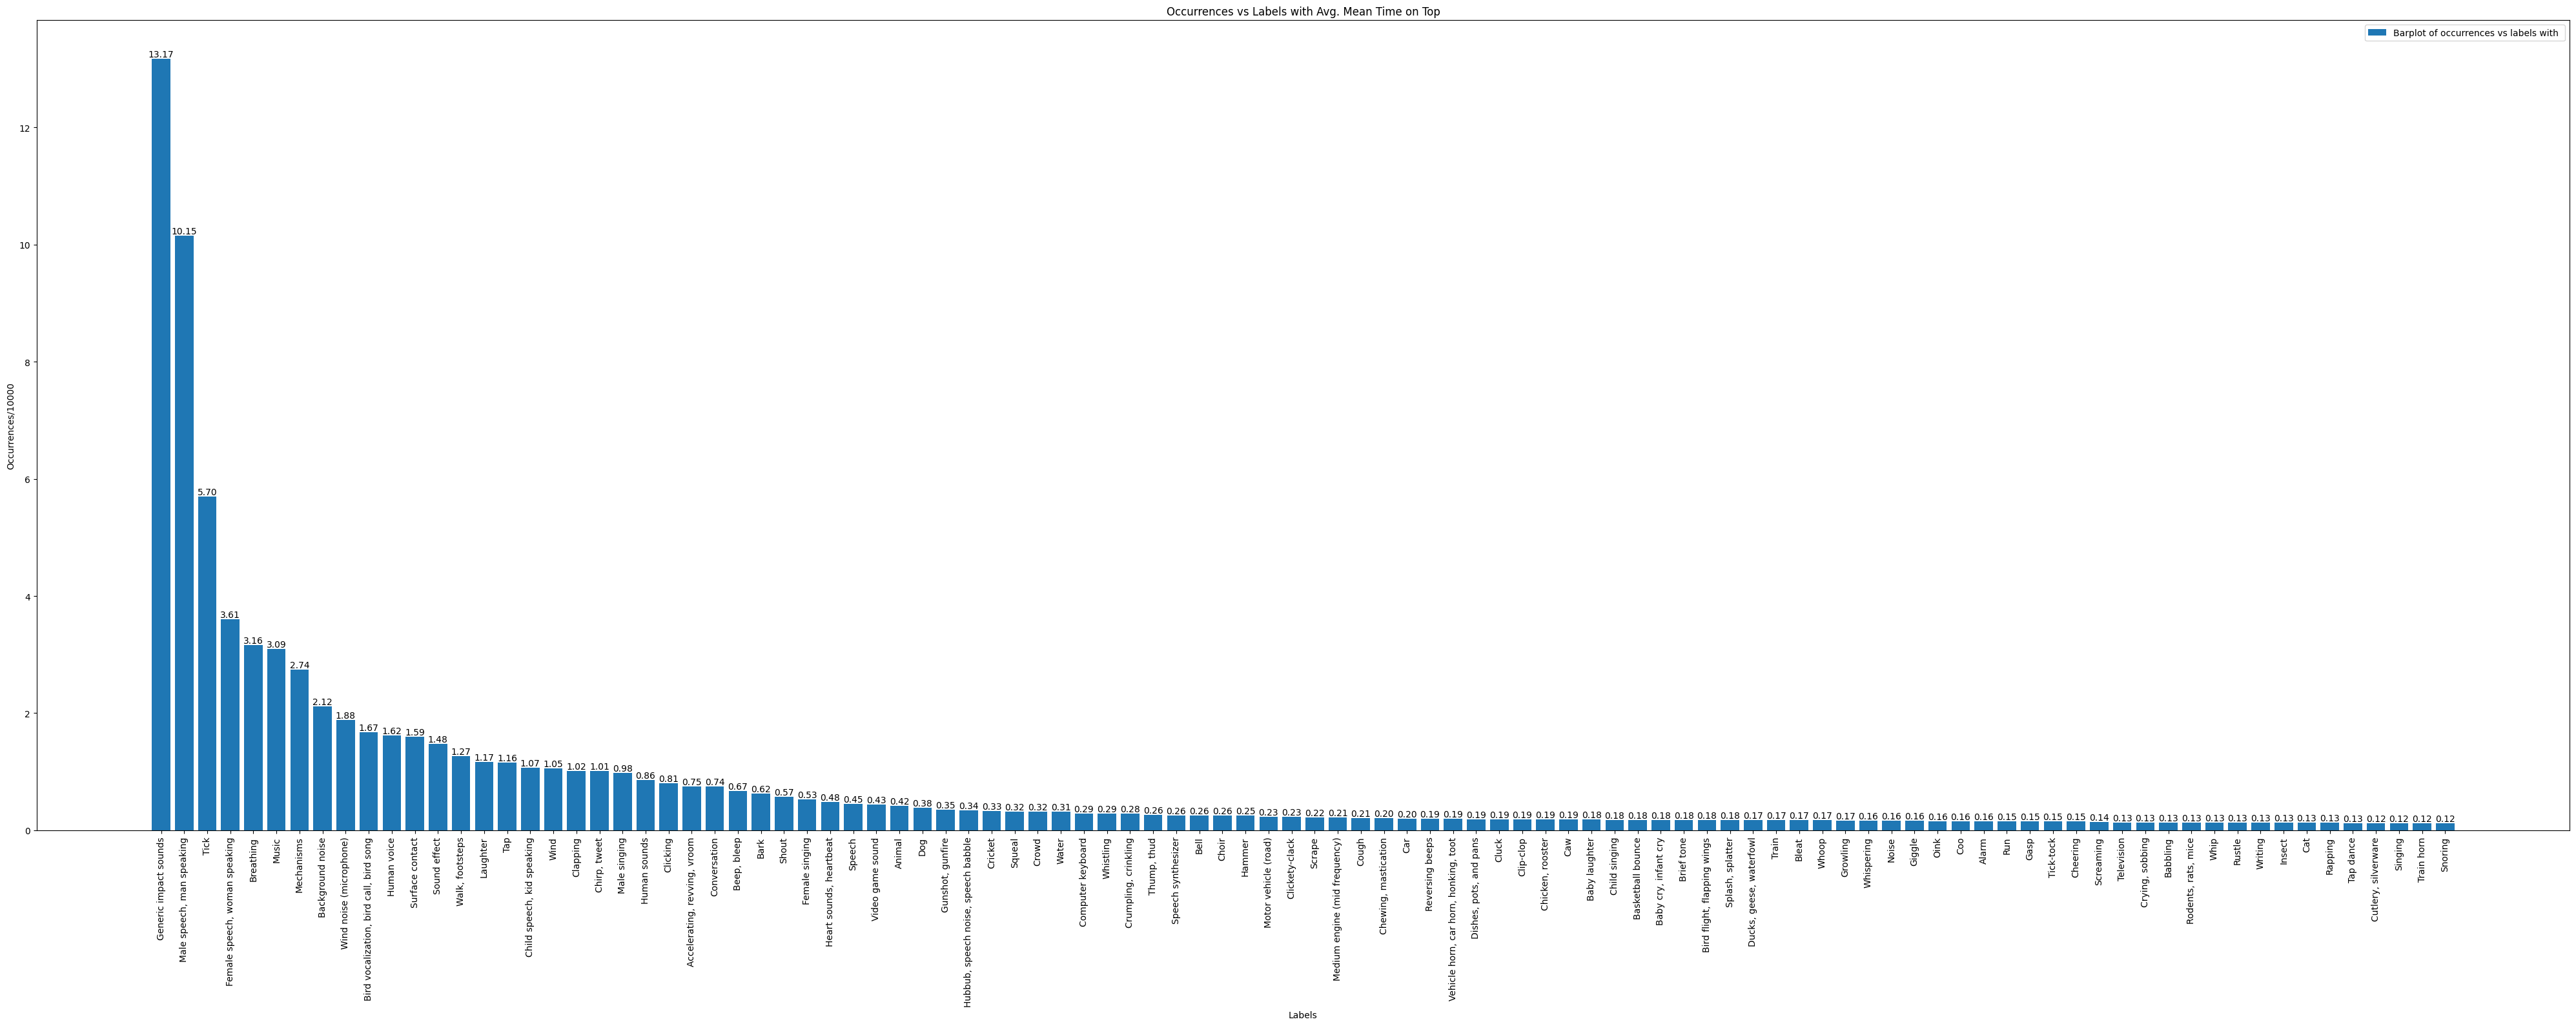

<Figure size 640x480 with 0 Axes>

In [4]:

# Calculating duration and occurrence count
df['duration'] = df['end_time_seconds'] - df['start_time_seconds']
label_stats = df.groupby('label').agg(occurrences=('label', 'size'), mean_duration=('duration', 'mean')).reset_index()

# Sorting by occurrence count
label_stats_sorted = label_stats.sort_values(by='occurrences', ascending=False)

# If more than 100 labels, limit to top 100
label_stats_sorted_backup = label_stats_sorted
if len(label_stats_sorted) > 100:
    label_stats_sorted = label_stats_sorted[:100]
for i, row in label_stats_sorted.iterrows():
    label_stats_sorted.at[i, 'label'] = id_to_label[row['label']]

# divde occurence count by 10000
label_stats_sorted['occurrences'] = label_stats_sorted['occurrences']/10000
# Plotting
plt.figure(figsize=(40, 16))
bars = plt.bar(label_stats_sorted['label'], label_stats_sorted['occurrences'])

# Adding mean duration on top of bars
for bar, frequency in zip(bars, label_stats_sorted['occurrences']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{(frequency):.2f}', 
             ha='center', va='bottom')
plt.legend(['Barplot of occurrences vs labels with '])
plt.xticks(rotation=90)
plt.xlabel('Labels')
plt.ylabel('Occurrences/10000')
plt.title('Occurrences vs Labels with Avg. Mean Time on Top')
plt.tight_layout()
plt.show()

# save the plot
plt.savefig('occurrences_vs_labels.png')


/tmp/ipykernel_19109/2298335398.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = label_stats_sorted_backup.groupby('duration_bin').size()


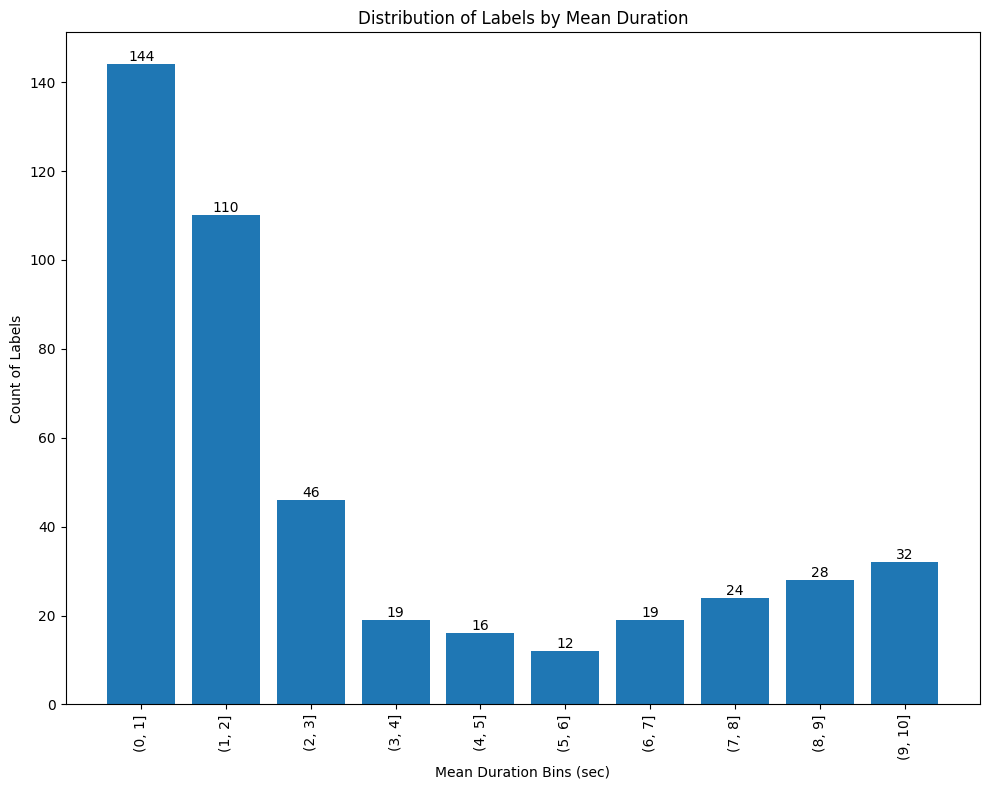

(None, '/mnt/data/labels_by_mean_duration.png')

In [16]:
import numpy as np
bins = np.arange(0, 11, 1)
label_stats_sorted_backup['duration_bin'] = pd.cut(label_stats_sorted_backup['mean_duration'], bins=bins)

# Count the number of labels in each bin
bin_counts = label_stats_sorted_backup.groupby('duration_bin').size()

# Plotting
plt.figure(figsize=(10, 8))
bar_plot = plt.bar(bin_counts.index.astype(str), bin_counts.values)
# give number of labels on top of bars
for bar, count in zip(bar_plot, bin_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count}', 
             ha='center', va='bottom')

plt.xticks(rotation=90)
plt.xlabel('Mean Duration Bins (sec)')
plt.ylabel('Count of Labels')
plt.title('Distribution of Labels by Mean Duration')
plt.tight_layout()

plt.show(), '/mnt/data/labels_by_mean_duration.png'